![MLA Logo](https://drive.corp.amazon.com/view/mrruckma@/MLA_headerv2.png?download=true)

In [1]:
!pip install --upgrade pip
!pip install -U scikit-image

    100% |████████████████████████████████| 1.5MB 20.4MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
     |████████████████████████████████| 12.3 MB 28.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 49.4 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 5.6 MB/s  eta 0:00:01
     |████████████████████████████████| 132 kB 57.5 MB/s eta 0:00:01
     |████████████████████████████████| 18.1 MB 54.0 MB/s eta 0:00:01
  Attempting uninstall: PyWavelets
    Found existing installation: PyWavelets 0.5.2
    Uninstalling PyWavelets-0.5.2:
      Successfully uninstalled PyWavelets-0.5.2
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1


### 1. Download the Dataset

Our labels correspondend to the following:

    Class 0: Inconclusive
    Class 1: Two wheels
    Class 2: Four wheels
    Class 3: Not luggage
    Class 4: Zero wheels



We are reading it into a Data Frame. 

In [3]:
#Let's read in our training data. ASINs correspond to those in Leaderboard's ID.
import pandas as pd

df = pd.read_pickle("/tmp/training_data.pkl")

df.head()

,ID,data,label
0,1588,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
1,2011,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
2,1321,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
3,669,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3
4,1674,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1


Let's plot some images below.

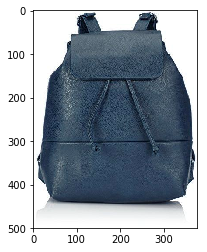

In [97]:
#Let's see what kind of data we're working with
import matplotlib.pyplot as plt

plt.imshow(df['data'][91])

In [4]:
# Let's take a look at this data in more detail and then start working. Remember 'label' is our target variable/column
df.loc[91].label


4

### 2. Split the dataset and Process Images
#### * We split the original dataset into Training (80%), Validation (10%) and Test (10%) subsets. 
#### * We will process images by resizing to 224x224 and converting (row, column, channel) to (channel, row, column)

In [5]:
import numpy as np
from skimage.transform import resize
from mxnet import gluon

# Let's split to data into training (90%), validation (10%) subsets (test is seperate file).
train_indices = np.arange(0, int(0.9*len(df)))
val_indices = np.arange(int(0.9*len(df)), len(df))
test_indices = np.arange(int(0.9*len(df)), len(df))

# balance test data a little
#for i in range(train_indices.size):
#    if df.loc[train_indices[i]].label == 0 or df.loc[train_indices[i]].label == 3 :
#        train_indices = np.append(train_indices, np.full(1, train_indices[i]))

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]
test_df = df.iloc[test_indices]

del df

def getImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224), dtype="float32")
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im

    return image_arr
    
train_images, train_labels = getImages(train_df["data"].values), train_df["label"].values
validation_images, validation_labels = getImages(val_df["data"].values), val_df["label"].values
test_images, test_labels = getImages(test_df["data"].values), test_df["label"].values

# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(train_images, train_labels)
validation_dataset = gluon.data.ArrayDataset(validation_images, validation_labels)

### 3. Plot the training class distribution

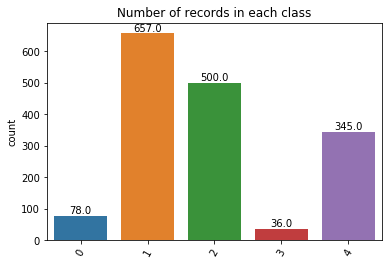

In [100]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=train_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

### 3. Plot the test class distribution

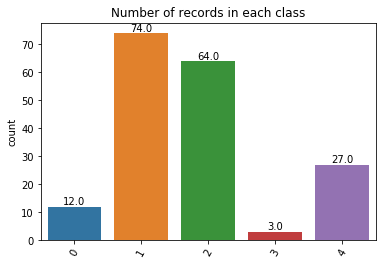

In [101]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=test_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

### 4. Confusion Matrix 
#### We have the following function to plot confusion matrix. We will call this function to plot confusion matrix for our validation data after each epoch (one full pass through the training dataset)


In [102]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in ['0', '1', '2', '3', '3']], columns = [i for i in ['0', '1', '2', '3', '4']])
    plt.figure(figsize = (5, 5))
    plt.title('Validation Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    plt.show()

### 5. Training and Validation
#### We will do the following:
#### * Create a simple Convolutional Neural Network (2 conv-pool pairs + flattening + softmax)
#### * Use the following hyper-parameters: batch size, epochs, learning rate. You can experiment with different values, but we will discuss those in greater detail tomorrow
#### * Calculate the loss and accuracy for training and validation at each epoch and print them at the end of each epoch.
#### * Plot the confusion matrix at the end of each epoch. 

Epoch 0, training loss: 1.45, validation loss: 1.36, training accuracy: 0.39, validation accuracy: 0.41


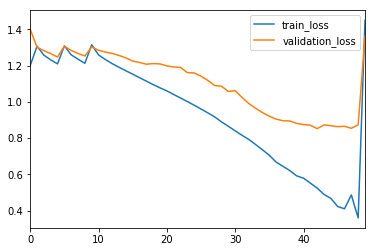

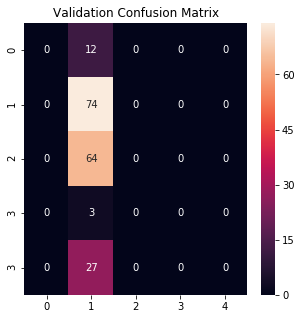

Epoch 1, training loss: 1.31, validation loss: 1.30, training accuracy: 0.39, validation accuracy: 0.41


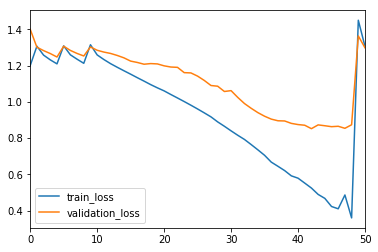

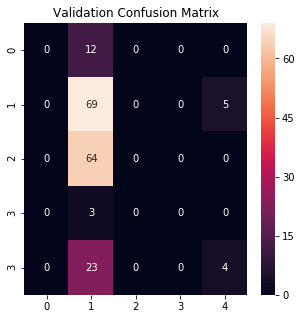

Epoch 2, training loss: 1.27, validation loss: 1.26, training accuracy: 0.41, validation accuracy: 0.39


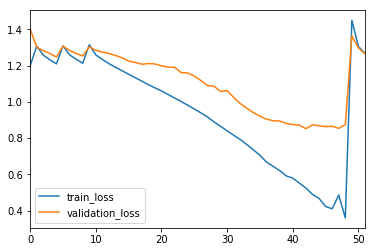

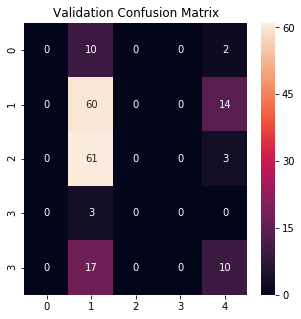

Epoch 3, training loss: 1.24, validation loss: 1.22, training accuracy: 0.44, validation accuracy: 0.41


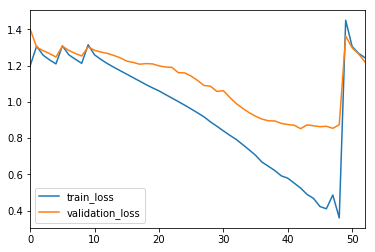

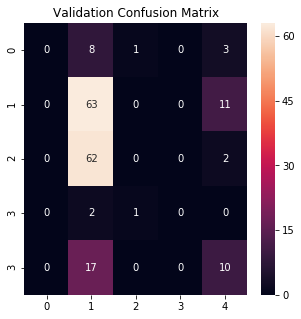

Epoch 4, training loss: 1.20, validation loss: 1.24, training accuracy: 0.46, validation accuracy: 0.41


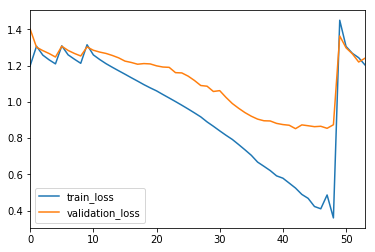

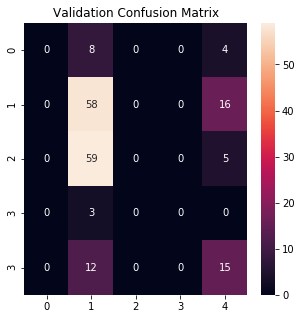

Epoch 5, training loss: 1.16, validation loss: 1.21, training accuracy: 0.47, validation accuracy: 0.40


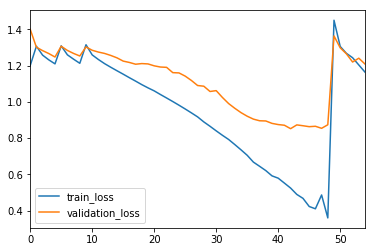

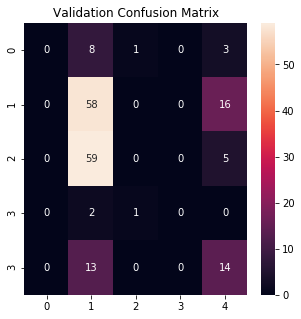

Epoch 6, training loss: 1.13, validation loss: 1.19, training accuracy: 0.49, validation accuracy: 0.42


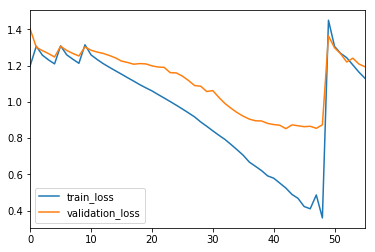

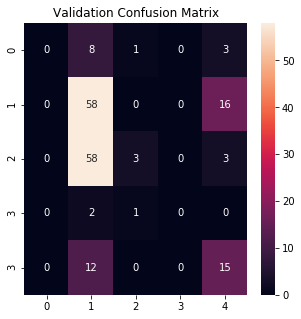

Epoch 7, training loss: 1.10, validation loss: 1.21, training accuracy: 0.51, validation accuracy: 0.42


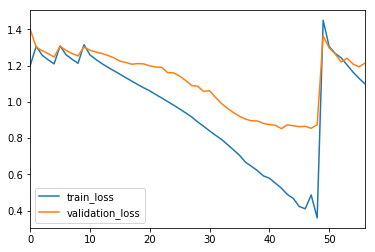

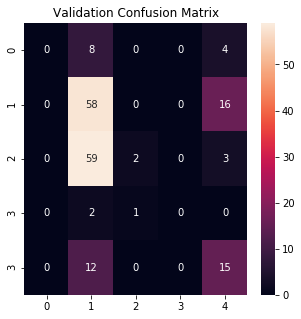

Epoch 8, training loss: 1.05, validation loss: 1.25, training accuracy: 0.53, validation accuracy: 0.44


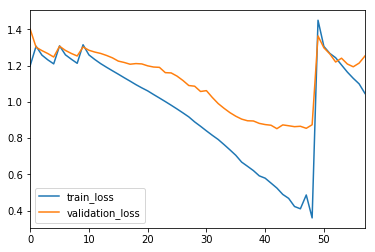

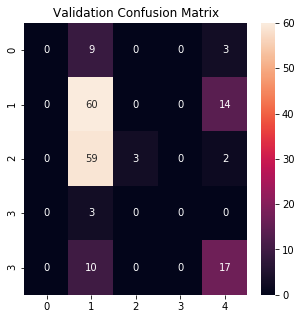

Epoch 9, training loss: 1.04, validation loss: 1.16, training accuracy: 0.55, validation accuracy: 0.47


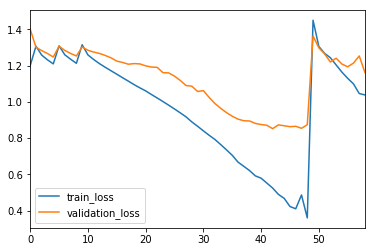

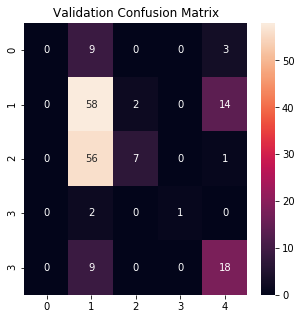

In [117]:
import mxnet as mx
from mxnet import gluon, autograd, ndarray
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
import mxnet.ndarray as nd
from sklearn.metrics import accuracy_score

# Set this to CPU or GPU depending on your training instance
# ctx = mx.cpu()
ctx = mx.gpu()

# Hyper-paramaters of the system
batch_size = 64
epochs = 10
learning_rate = 0.03

# Create the network. We have 5 classes
num_outputs = 5
    
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=60, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # The Flatten layer collapses all axis, except the first one, into one axis.
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(512, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))
    
# Initialize parameters
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# Define loss and trainer.
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

train_losses = []
valid_losses = []

# Starting the outer loop, we will have 3 epochs (3 full pass through our dataset)
for epoch in range(epochs):
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    cumulative_train_loss = 0
    train_predictions = []
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
    
    # Calculating the Softmax Cross Entopy Loss for training
    train_loss = cumulative_train_loss/len(train_images)

    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    cumulative_valid_loss = 0
    val_predictions = []
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
    valid_loss = cumulative_valid_loss/len(validation_images)

    # graph training loss
    train_losses.append(train_loss.asnumpy()[0])
    valid_losses.append(valid_loss.asnumpy()[0])
    pd.DataFrame({'train_loss':train_losses, 'validation_loss': valid_losses}).plot()
    
    # Calculate training and validation accuracies
    # I used a accuracy_score() function from the sklearn library here. 
    # accuracy = (TP+TN) / (TP+FP+TN+FN)
    train_accuracy = accuracy_score(train_labels.tolist(), train_predictions)
    validation_accuracy = accuracy_score(validation_labels.tolist(), val_predictions)
    
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    plot_confusion_matrix(validation_labels.tolist(), val_predictions)

# 6. Test on test dataset
#### We are done with the training and validation. Let's get the test predictions below. 

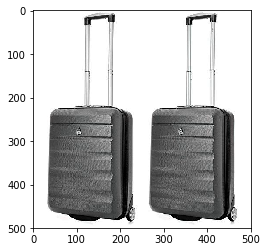

In [106]:
# If you're unsure of how to submit to Leaderboard, no problemo.You'll use the training file loaded above to make your ML model and then predict on the files below:

test_df = pd.read_pickle("/tmp/test_data.pkl")
plt.imshow(test_df['data'][90])

In [107]:
test_images = getImages(test_df["data"].values)
test_loader = gluon.data.DataLoader(test_images, batch_size=batch_size)

test_predictions = []
for i, data in enumerate(test_loader):
    data = data.as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

[4, 1, 1, 2, 0, 1, 0, 1, 4, 1, 2, 4, 2, 1, 1, 2, 4, 1, 4, 1, 2, 4, 4, 1, 2, 2, 2, 1, 1, 0, 1, 3, 4, 2, 1, 0, 2, 1, 3, 1, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 4, 2, 4, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 2, 4, 2, 2, 1, 1, 1, 1, 4, 1, 2, 4, 2, 1, 0, 4, 4, 1, 4, 2, 4, 2, 1, 1, 2, 1, 2, 1, 1, 2, 4, 2, 2, 4, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 4, 1, 4, 1, 2, 4, 2, 2, 4, 1, 2, 2, 2, 2, 4, 2, 2, 1, 4, 2, 2, 2, 1, 2, 4, 1, 4, 2, 1, 4, 3, 2, 4, 2, 1, 2, 1, 4, 4, 1, 4, 2, 2, 0, 2, 2, 4, 4, 3, 1, 0, 4, 2, 1, 1, 1, 1, 2, 2, 4, 2, 4, 4, 2, 1, 1, 4, 4, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 4, 4, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 4, 1, 2, 4, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 4, 2, 2, 0, 4, 2, 1, 1, 2, 4, 2, 2, 2, 1, 1, 1, 4, 2, 1, 2, 2, 1, 1, 4, 2, 1, 1, 1, 1, 2, 4, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 2, 2, 2, 4, 1, 2, 1, 1, 1, 1, 2, 4, 0, 2, 4, 2, 1, 2, 4, 1, 1, 1, 1, 4, 1, 2, 1, 2, 0, 2, 0, 2, 2, 2, 4, 2, 

In [109]:
import pandas as pd

result_df = pd.DataFrame(columns=['ID', 'label'])
result_df["ID"] = test_df["ID"]
result_df["label"] = test_predictions

result_df.to_csv("results_cv_example.csv", index=False)

If you navigate to the day1/results folder in the Jupyter file browser, you can select the results_cv_project.csv and dowload it locally. Or just click this [link...](./results_cv_project.csv)

## Getting our model output into Leaderboard

We now have our model's output .csv and are ready to upload to Leaderboard
1. Go to your class [Leaderboard instance](https://leaderboard.corp.amazon.com/tasks/312) and go to the 'Make a Submission' section
2. Upload your local file and include your notebook version URL for tracking
3. Your score on the public leaderboard should now appear. Marvel on how much room for improvement there is